### TensorFLow 
- TFLite : for android above oreo
- tensor is an n-dim array
    - 1-d tensor, 2-d tensor, 3-d tensor, n-d tensor
    
cpu vs gpu
- cache : on chip m/m

gpu:
- 100 or 1000 of cores
- each gpu core is much slower than cpu cores
    - each core has cache
    - sum of all cache is vram
- cuda
    - it is a toolbox to program nvidea GPU
    - ie. how to split data in distributed cacche and operate

gpu's are fast for parallelizable task. Matrix operations leverage thhis 
- deel learning has matrix or vector operations

### Softmax using TensorFlow

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
import numpy as np

In [3]:
mnist.train.images.shape

(55000, 784)

In [4]:
mnist.test.images.shape

(10000, 784)

In [5]:
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13824930368070861206
]


### Tensorflow
- constants : cannot be changed
- variables : can be updatead and changed
- placeholders : a m/m location
    - suppose we are training minibatch with 100xi
    - used to define transient things like minibatches
    


In [8]:
x = tf.placeholder(tf.float32, [None,784])
# two dimensions and None means not defined
# it can hold 32 bit foating pt values
# we are defining only one of the dimensions

w = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

In [9]:
y = tf.nn.softmax(tf.matmul(x,w)+b)
y_ = tf.placeholder(tf.float32, [None,10])

In [10]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=1))
# index 1: row sum
# index 0 : column sum
# cross entropy is log loss for multi class

In [16]:
train = tf.train.GradientDescentOptimizer(0.05)
train_step = train.minimize(cross_entropy)

In [17]:
sess = tf.InteractiveSession()
# tf converts everything in computational graph

tf.global_variables_initializer().run()

C:\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [18]:
for _ in range(1000):
    batch_xs,batch_ys = mnist.train.next_batch(100) # this returns a minibatch
    sess.run(train_step, feed_dict={x: batch_xs, y_:batch_ys})

In [20]:
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_:mnist.test.labels}))

0.9009


In [63]:
import matplotlib.pyplot as plt

### MLP : MNIST

In [64]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [65]:
# Network Parameters
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [66]:
# x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation.
# We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. 
# We represent this as a 2-D tensor of floating-point numbers, with a shape X = [None, 784]. 
# (Here None means that a dimension can be of any length.)
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# keep_prob: we will be using these placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)
# keep_prob_input: we will be using these placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [67]:
# Weight initialization

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# https://www.tensorflow.org/api_docs/python/tf/random_normal
# Outputs random values from a normal distribution mean=0 std=1

# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(fan_in+fan_out+1) = 0.039  => N(0,σ) = N(0,0.039)
# h2 =>  σ=√(2/(fan_in+fan_out+1) = 0.055  => N(0,σ) = N(0,0.055)
# out =>  σ=√(2/(fan_in+fan_out+1) = 0.120  => N(0,σ) = N(0,0.120)
# SGD: Xavier/Glorot Normal initialization.
weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.039, mean=0)),    #784x512 # sqrt(2/(784+512)) = 0.039
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.055, mean=0)), #512x128 # sqrt(2/(512+128)) = 0.055
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# for relu lates
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
# h1 =>  σ=√(2/(fan_in+1) = 0.062  => N(0,σ) = N(0,0.062)
# h2 =>  σ=√(2/(fan_in+1) = 0.125  => N(0,σ) = N(0,0.125)
# out =>  σ=√(2/(fan_in+1) = 0.120  => N(0,σ) = N(0,0.120)
# He Normal initialization.
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)),    #784x512
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)), #512x128
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             #512x1
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),             #128x1
    'out': tf.Variable(tf.random_normal([n_classes]))              #10x1
}

In [68]:
# Parameters
training_epochs = 5
learning_rate = 0.001
batch_size = 500
display_step = 1 # numbr of epochs after whihc we will
    # update this plot

#### Model 1: input (784) - sigmoid(512) - sigmoid(128) - softmax(output 10)


In [70]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

#### Model 1 + AdamOptimizer


In [71]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sgd, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.895522936 test cost=1.885769820
Epoch: 0002 train cost=1.627232697 test cost=1.621076144
Epoch: 0003 train cost=1.573457852 test cost=1.570924296
Epoch: 0004 train cost=1.551098015 test cost=1.548556032
Epoch: 0005 train cost=1.535585362 test cost=1.535470642
Accuracy: 0.9341


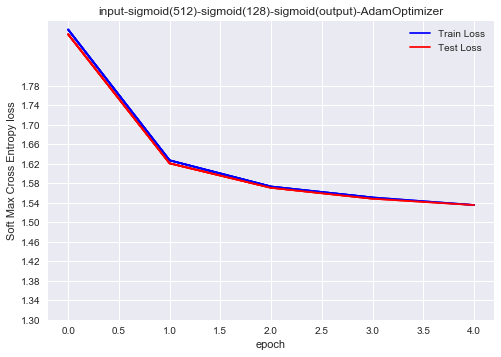

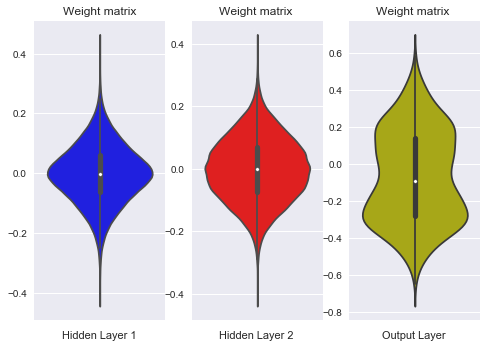

In [72]:
# plot weight dist at the end of training
import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)

fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

### model 1 + gradient descent optimizer

In [78]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('epoch'); ax.set_ylabel('Soft Max Cross Entropy loss')
    xs,ytrs,ytes = [],[],[]
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use Gradient Descent Optimizer
            _, c,w = sess.run([optimizer_sgdc,cost_sgd,weights_sgd],feed_dict={x:batch_xs, y_: batch_ys} )
            train_avg_cost+= c/total_batch
            c = sess.run(cost_sgd, feed_dict= {x : mnist.test.images, y_:mnist.test.labels})
            test_avg_cost+= c/total_batch
        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs,ytrs, ytes, ax,np.arange(2, 2.6, step=0.05), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-GradientDescentOptimizer")
        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    
    correct_prediction = tf.equal(tf.argmax(y_sgd,1),tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

Epoch: 0001 train cost=2.351864871 test cost=2.349196555
Epoch: 0002 train cost=2.351080728 test cost=2.348569688
Epoch: 0003 train cost=2.349227010 test cost=2.347948144
Epoch: 0004 train cost=2.349540290 test cost=2.347319577
Epoch: 0005 train cost=2.348848104 test cost=2.346684996
Accuracy: 0.0974


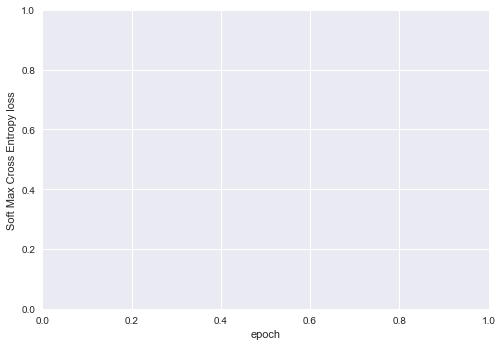

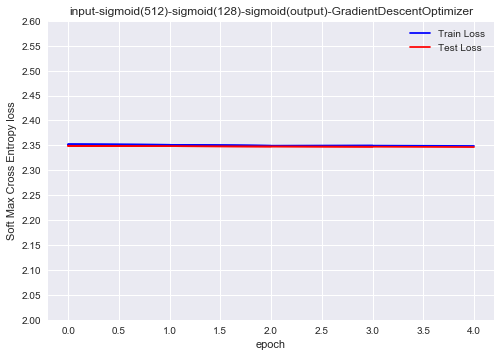

In [79]:
plt.show()

### Plotting violin plot for all the weights

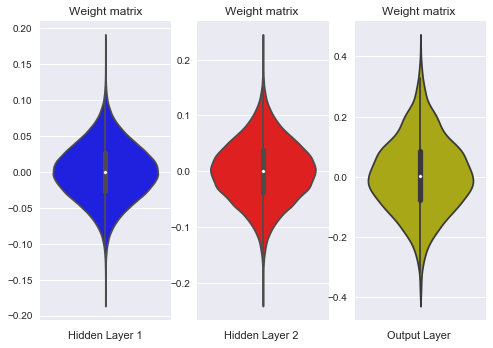

In [82]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

### Model 2 : input 784 - relu 512 - relu 128 - sigmoid 10

In [83]:
def multilayer_perceptron_relu(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with ReLu activation
    # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

In [86]:
yrelu = multilayer_perceptron_relu(x, weights_relu, biases)

cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=yrelu, labels=y_))

optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)
optimizer_relu_sgd = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    epochs, train_cost_list, test_cost_list = [],[],[]
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _,c,w = sess.run([optimizer_relu_adam,cost_relu,weights_relu],feed_dict={x:batch_xs,y_:batch_ys})
            train_avg_cost += c/total_batch
            c = sess.run(cost_relu, feed_dict={ x : mnist.test.images, y_: mnist.test.labels})
            test_avg_cost +=c/total_batch
            
        epochs.append(epoch)
        train_cost_list.append(train_avg_cost)
        test_cost_list.append(test_avg_cost)
        
        if epoch % display_step ==0:
            print("epoch ",epoch," train cost: ",train_avg_cost," test cost:", test_avg_cost)
    
    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy : ", accuracy.eval({x:mnist.test.images, y_:mnist.test.labels}))

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
epoch  0  train cost:  1.6314010067419573  test cost: 1.6189153281125155
epoch  1  train cost:  1.5243644367564813  test cost: 1.5227911602367057
epoch  2  train cost:  1.5066643996672202  test cost: 1.50729137767445
epoch  3  train cost:  1.4958153540437873  test cost: 1.4991808967156848
epoch  4  train cost:  1.489557307416742  test cost: 1.4942730860276658
Accuracy :  0.9683


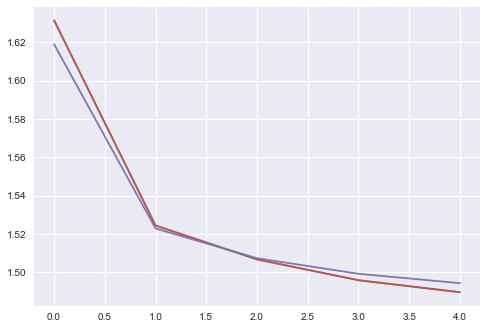

In [90]:
plt.plot(epochs,train_cost_list,label="train error")
plt.plot(epochs,test_cost_list,label="test error")
plt.show()

#### Model 3 : input - sigmoid ( Batch normalization 512) - sigmoid(Batch-normalization 128 ) - sigmoid output

In [91]:
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    ##################################################
    # Hidden layer with sigmoid activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1,epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    ##################################################
    # hidden layer with sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    
    # calculate the mean and variance of x
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2 , scale_2, epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    ######################################################################################
    
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer
    

In [92]:
ybatch = multilayer_perceptron_batch(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    epochs, train_cost_list, test_cost_list = [],[],[]
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _,c,w = sess.run([optimizer_batch_adam,cost_relu,weights_relu],feed_dict={x:batch_xs,y_:batch_ys})
            train_avg_cost += c/total_batch
            c = sess.run(cost_relu, feed_dict={ x : mnist.test.images, y_: mnist.test.labels})
            test_avg_cost +=c/total_batch
            
        epochs.append(epoch)
        train_cost_list.append(train_avg_cost)
        test_cost_list.append(test_avg_cost)
        
        if epoch % display_step ==0:
            print("epoch ",epoch," train cost: ",train_avg_cost," test cost:", test_avg_cost)
    
    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy : ", accuracy.eval({x:mnist.test.images, y_:mnist.test.labels}))

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
epoch  0  train cost:  2.349108878048983  test cost: 2.348698134855791
epoch  1  train cost:  2.349044199423356  test cost: 2.3484350269491023
epoch  2  train cost:  2.349232266165994  test cost: 2.348245159062473
epoch  3  train cost:  2.3494993925094607  test cost: 2.3481193390759563
epoch  4  train cost:  2.3483504490418876  test cost: 2.348028885234485
Accuracy :  0.1013


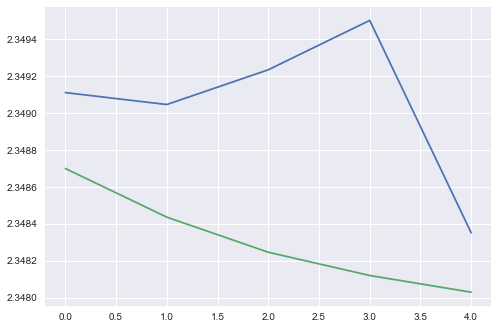

In [93]:
plt.plot(epochs,train_cost_list,label="train error")
plt.plot(epochs,test_cost_list,label="test error")
plt.show()

#### Input : relu512 - dropout-relu128 - dropout-sigmoid


In [94]:
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

In [97]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    epochs, train_cost_list, test_cost_list = [],[],[]
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _,c,w = sess.run([optimizer_drop_adam,cost_relu,weights_relu],feed_dict={x:batch_xs,y_:batch_ys,keep_prob:0.5})
            train_avg_cost += c/total_batch
            c = sess.run(cost_relu, feed_dict={ x : mnist.test.images, y_: mnist.test.labels, keep_prob:1.0})
            test_avg_cost +=c/total_batch
            
        epochs.append(epoch)
        train_cost_list.append(train_avg_cost)
        test_cost_list.append(test_avg_cost)
        
        if epoch % display_step ==0:
            print("epoch ",epoch," train cost: ",train_avg_cost," test cost:", test_avg_cost)
    
    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy : ", accuracy.eval({x:mnist.test.images, y_:mnist.test.labels}))


x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
epoch  0  train cost:  1.6968835353851315  test cost: 1.68552002581683
epoch  1  train cost:  1.5484350312839854  test cost: 1.5446489290757615
epoch  2  train cost:  1.5224495605988932  test cost: 1.520435202121735
epoch  3  train cost:  1.5122143929654899  test cost: 1.510600087859414
epoch  4  train cost:  1.5046550176360391  test cost: 1.504612382975492
Accuracy :  0.9501


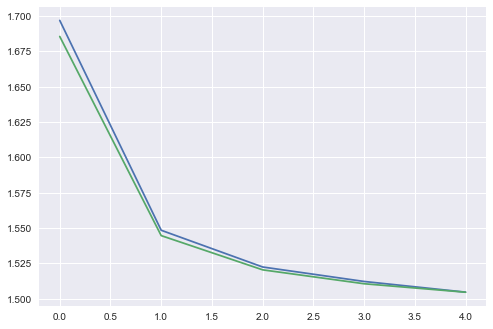

In [98]:
plt.plot(epochs,train_cost_list,label="train error")
plt.plot(epochs,test_cost_list,label="test error")
plt.show()